In [1]:
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import seaborn as sns
import numpy as np
from collections import Counter

data prep

In [4]:
X,y=make_multilabel_classification(n_samples=10000, n_features=10, n_classes=3, n_labels=2)
X_torch = torch.FloatTensor(X)
y_torch = torch.FloatTensor(y)

train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_torch, y_torch, test_size = 0.2)


dataset and dataloader

In [6]:
class MultiLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 
    
multiLabelDataset=MultiLabelDataset(X_train, y_train)
train_loader = DataLoader(dataset = multiLabelDataset, batch_size=10)

model

In [35]:
class MultiLabelNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiLabelNetwork, self).__init__()  
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    

input_dim = X_torch.shape[1]
output_dim = y_torch.shape[1]
model = MultiLabelNetwork(input_size=input_dim, hidden_size=20, output_size=output_dim)
model.train()
# %%
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []
slope, bias = [], []
number_epochs = 60
for epoch in range(number_epochs):
    for j, data in enumerate(train_loader):
        
        # optimization
        optimizer.zero_grad()

        # forward pass
        y_hat = model(data[0])

        # compute loss
        loss = loss_fn(y_hat, data[1])
        

        # backprop
        loss.backward()

        # update weights
        optimizer.step()
    losses.append(loss.item())    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.6882078647613525
Epoch 10, Loss: 0.6643155217170715
Epoch 20, Loss: 0.6996158361434937
Epoch 30, Loss: 0.7043032050132751
Epoch 40, Loss: 0.7101715207099915
Epoch 50, Loss: 0.6167508363723755


losses

<Axes: >

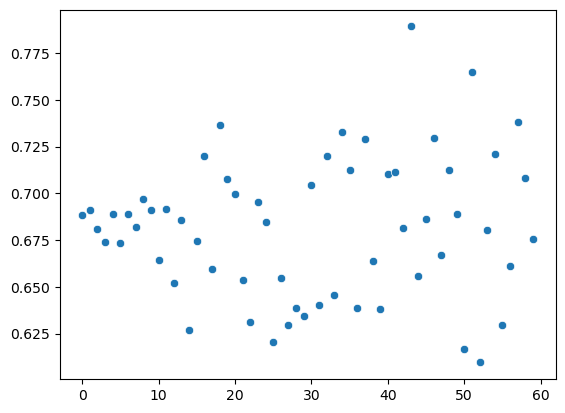

In [36]:
sns.scatterplot(x=range(len(losses)), y=losses)

test the model

In [37]:
X_test_torch = torch.FloatTensor(X_test)
with torch.no_grad():
    y_test_hat = model(X_test_torch).round()

Naive classifier accuracy

In [38]:
y_test_str = [str(i) for i in y_test.detach().numpy()]
y_test_str

['[0. 0. 0.]',
 '[1. 0. 1.]',
 '[0. 0. 0.]',
 '[0. 1. 1.]',
 '[1. 1. 1.]',
 '[0. 1. 1.]',
 '[0. 0. 0.]',
 '[0. 1. 1.]',
 '[1. 1. 0.]',
 '[0. 0. 1.]',
 '[1. 1. 1.]',
 '[1. 1. 1.]',
 '[1. 1. 1.]',
 '[1. 1. 1.]',
 '[0. 0. 0.]',
 '[1. 1. 1.]',
 '[0. 0. 0.]',
 '[1. 0. 0.]',
 '[1. 0. 1.]',
 '[1. 1. 0.]',
 '[0. 1. 0.]',
 '[0. 1. 0.]',
 '[0. 0. 0.]',
 '[1. 1. 0.]',
 '[0. 1. 0.]',
 '[1. 0. 0.]',
 '[1. 1. 0.]',
 '[0. 1. 1.]',
 '[1. 1. 1.]',
 '[0. 0. 0.]',
 '[0. 0. 0.]',
 '[0. 1. 1.]',
 '[1. 1. 1.]',
 '[1. 1. 1.]',
 '[0. 0. 0.]',
 '[1. 1. 1.]',
 '[1. 0. 0.]',
 '[0. 0. 0.]',
 '[1. 1. 0.]',
 '[1. 1. 1.]',
 '[1. 1. 0.]',
 '[0. 0. 0.]',
 '[1. 1. 1.]',
 '[0. 0. 1.]',
 '[0. 1. 0.]',
 '[1. 1. 1.]',
 '[0. 1. 1.]',
 '[0. 1. 0.]',
 '[0. 1. 1.]',
 '[1. 1. 0.]',
 '[0. 1. 1.]',
 '[0. 1. 0.]',
 '[1. 0. 1.]',
 '[0. 1. 0.]',
 '[0. 1. 1.]',
 '[0. 0. 0.]',
 '[0. 1. 1.]',
 '[0. 1. 0.]',
 '[1. 1. 0.]',
 '[0. 1. 1.]',
 '[0. 1. 1.]',
 '[0. 0. 0.]',
 '[1. 1. 0.]',
 '[0. 0. 0.]',
 '[0. 0. 0.]',
 '[0. 0. 0.]',
 '[1. 0. 0

In [39]:
most_common_cnt = Counter(y_test_str).most_common()[0][1]
print(f"Naive classifier: {most_common_cnt/len(y_test_str) * 100}%")


Naive classifier: 21.3%


Test accuracy

In [44]:
y_test_hat_2= (y_test_hat > 0.0).float()

In [47]:
test_acc = accuracy_score(y_test, y_test_hat_2)
print(f"Test accuracy: {test_acc * 100}%")

Test accuracy: 51.6%


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, and F1-score for multi-label classification
precision = precision_score(y_test, y_test_hat, average='samples')
recall = recall_score(y_test, y_test_hat, average='samples')
f1 = f1_score(y_test, y_test_hat, average='samples')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Precision: 74.45%
Recall: 64.22%
F1-Score: 66.64%


c:\Users\prane\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prane\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prane\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
